<a href="https://colab.research.google.com/github/PARULCHUTANIPC/parul/blob/p1/Dogs_vs_Cats_6_models%20but%20with%20some%20doubts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **IMPORTING THE LIBRARIES**

In [27]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline

from time import time
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

Using TensorFlow backend.


### **PREPARING THE DATASET**

**Fetching data set from Google Drive and Unzip it**

In [0]:
import os
import zipfile

local_zip = '/content/drive/My Drive/Colab Notebooks/DATASETS/CATS VS DOG PROPER DATASET.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

**Setting up the Directories**

In [0]:
base_dir = '/content/drive/My Drive/Colab Notebooks/DATASETS/CATS VS DOG PROPER DATASET'
train_dir = os.path.join('/content/CATS VS DOG PROPER DATASET/cats_and_dogs_ok/train')
validation_dir = os.path.join('/content/CATS VS DOG PROPER DATASET/cats_and_dogs_ok/validation')

#train_dir = os.path.join(base_dir, 'train')
#validation_dir = os.path.join(base_dir, 'validation')
# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

**Checking the image format - Channels-width-hight or width-height-channels**

In [0]:
if K.image_data_format() == 'channels_first':
  input_shape = (3, 224, 224)
else:
  input_shape = (224, 224, 3)

**Generating the images using image data generator**

In [31]:
training_data_generation = ImageDataGenerator(
    rotation_range=90,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1/255,
    zoom_range=0.4)

test_data_generation = ImageDataGenerator(rescale=1/255)


train_generator = training_data_generation.flow_from_directory(
        train_dir, 
        target_size=(224, 224), 
        batch_size=20,
        class_mode='binary')

validation_generator = test_data_generation.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary')

Found 25000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [10]:

print(train_generator.class_indices)

{'cats': 0, 'dogs': 1}


##**VISUALIZATION**##


**Assigning the images and labels to process further for identification**

In [0]:
test_images, test_labels = next(validation_generator)

**Visualizing the Dataset**

In [0]:
from skimage import io

def imshow(image_RGB):
  io.imshow(image_RGB)
  io.show()

20
1.0  random images from the training dataset


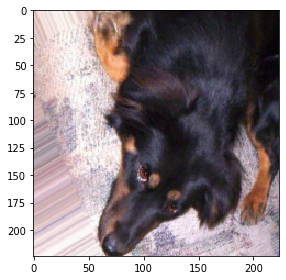

0.0  random images from the training dataset


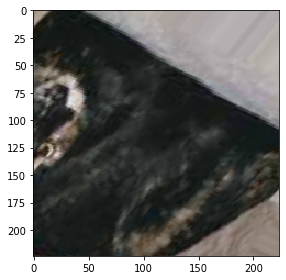

0.0  random images from the training dataset


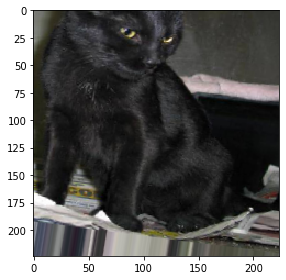

0.0  random images from the training dataset


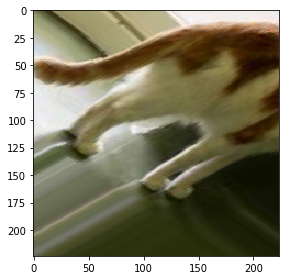

0.0  random images from the training dataset


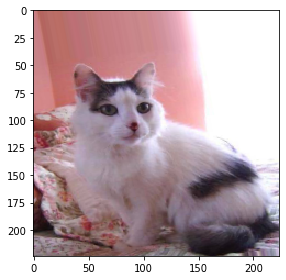

0.0  random images from the training dataset


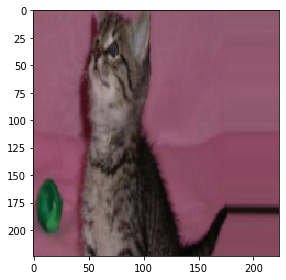

1.0  random images from the training dataset


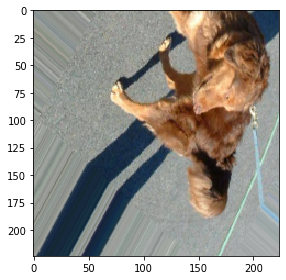

0.0  random images from the training dataset


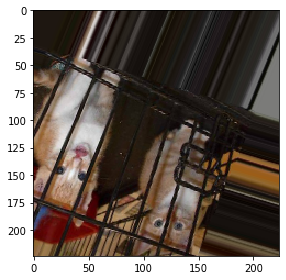

0.0  random images from the training dataset


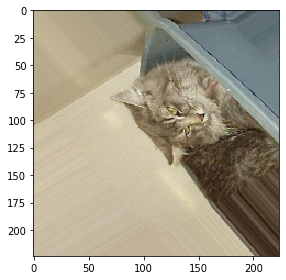

1.0  random images from the training dataset


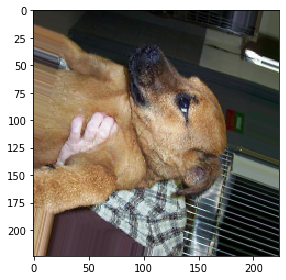

1.0  random images from the training dataset


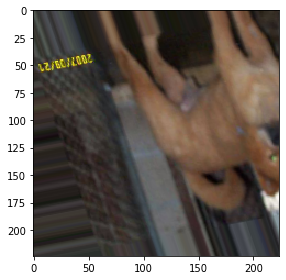

0.0  random images from the training dataset


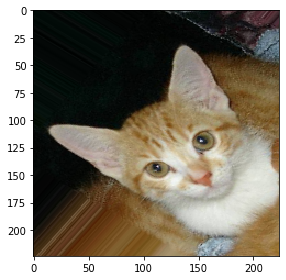

1.0  random images from the training dataset


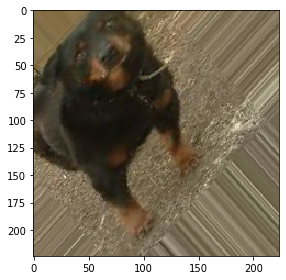

0.0  random images from the training dataset


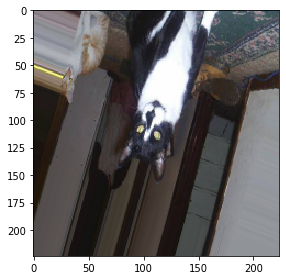

0.0  random images from the training dataset


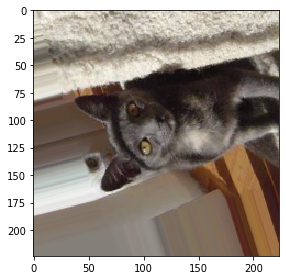

0.0  random images from the training dataset


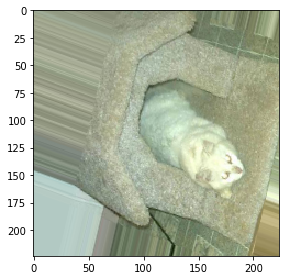

0.0  random images from the training dataset


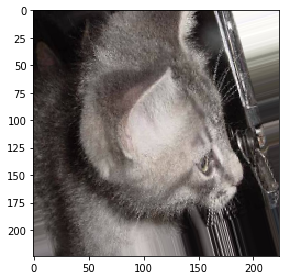

1.0  random images from the training dataset


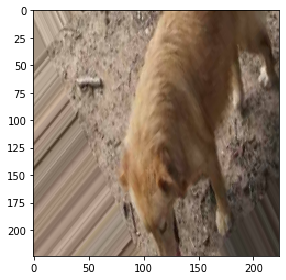

1.0  random images from the training dataset


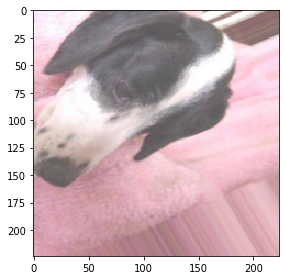

0.0  random images from the training dataset


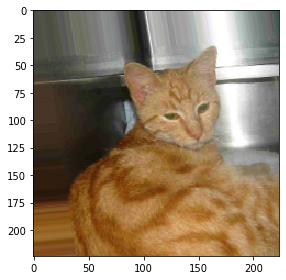

In [13]:
train_images,train_labels = train_generator.next()

print(len(train_images))
for i in range(0,len(train_images)):
    image = train_images[i]
    print(train_labels[i], " random images from the training dataset")
    imshow(image)

**
Visualizing the effect of DataGeneration, various changes in a single images are clearly visible**

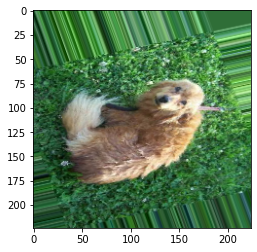

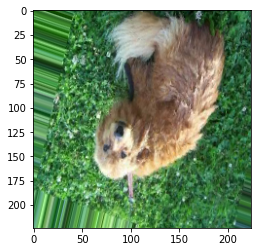

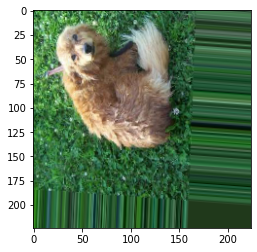

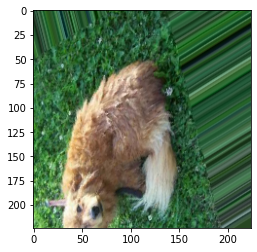

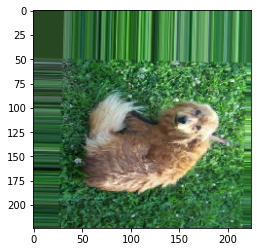

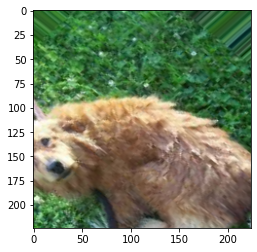

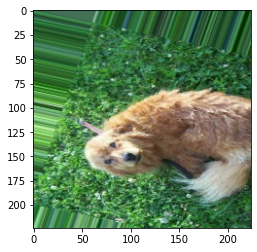

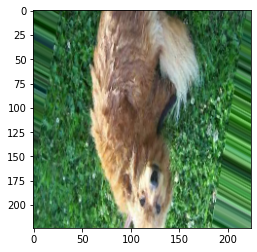

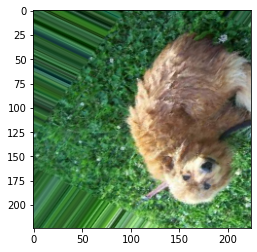

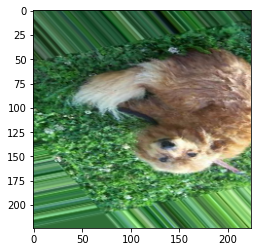

In [14]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

img_path = os.path.join(train_dogs_dir, train_dog_fnames[0])
img = load_img(img_path, target_size=(224, 224))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (224, 224, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 224, 224, 3)

# The .flow() command below generates batches of randomly transformed images
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in training_data_generation.flow(x, batch_size=1):
  plt.figure(i)
  imgplot = plt.imshow(array_to_img(batch[0]))
  i += 1
  if i % 10 == 0:
    break

##**PREPARING THE MODELS**##

**1. MODEL VGG16**

In [22]:
vgg16 = keras.applications.vgg16.VGG16()
baseModel_vgg16 = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
headModel_vgg16 = baseModel_vgg16.output


#headModel = tf.keras.AveragePooling2D(pool_size=(4, 4))(headModel)
headModel_vgg16 = Flatten(name="flatten")(headModel_vgg16)
headModel_vgg16 = Dense(128, activation="relu")(headModel_vgg16)
#headModel = Dropout(0.5)(headModel)

headModel_vgg16 = Dense(2, activation="softmax")(headModel_vgg16)
model_VGG16 = Model(inputs=baseModel_vgg16.input, outputs=headModel_vgg16)

for layer in baseModel_vgg16.layers:
	layer.trainable = False
print(model_VGG16.summary())

print("[INFO] compiling model_VGG16...")
opt = tf.keras.optimizers.Adam(lr=1e-4)
model_VGG16.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

start_time = time()
history = model_VGG16.fit_generator(train_generator, steps_per_epoch=1,epochs=1,Validation_data=validation_generator,validation_steps=10,verbose=1)
print('time taken ',time()-start_time)

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0  

**2. MODEL VGG19**

In [23]:
baseModel_vgg19 = keras.applications.vgg19.VGG19(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

#vgg19 = keras.applications.vgg19.VGG19()
#vgg19.summary()
#baseModel_vgg19 = vgg19(weights="imagenet", include_top=True) #,  #input_tensor=Input(shape=(224, 224, 3)))
headModel_vgg19 = baseModel_vgg19.output


#headModel = tf.keras.AveragePooling2D(pool_size=(4, 4))(headModel)
#headModel_vgg19 = Flatten(name="flatten")(headModel_vgg19)
headModel_vgg19 = Dense(128, activation="relu")(headModel_vgg19)
#headModel = Dropout(0.5)(headModel)

headModel_vgg19 = Dense(2, activation="softmax")(headModel_vgg19)
model_vgg19 = Model(inputs=baseModel_vgg19.input, outputs=headModel_vgg19)
for layer in baseModel_vgg19.layers:
	layer.trainable = False
print(model_vgg19.summary())


opt = tf.keras.optimizers.Adam(lr=1e-4)
model_vgg19.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0  

**3. Model ResNet50**

In [24]:
baseModel_resnet50 = keras.applications.resnet.ResNet50(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

headModel_resnet50 = baseModel_resnet50.output

headModel_resnet50 = Flatten(name="flatten")(headModel_resnet50)
headModel_resnet50 = Dense(128, activation="relu")(headModel_resnet50)

headModel_resnet50 = Dense(2, activation="softmax")(headModel_resnet50)
model_resnet50 = Model(inputs=baseModel_resnet50.input, outputs=headModel_resnet50)
for layer in baseModel_resnet50.layers:
	layer.trainable = False
print(model_resnet50.summary())


opt = tf.keras.optimizers.Adam(lr=1e-4)
model_resnet50.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_17[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

**4. Model InceptionV3.                                                                    ** 
**As Input shape required by this model is 299 * 299, so, data generation i srepeated to change the image size of our dataset as per the model requirement**

In [15]:
training_data_generation_InceptionV3 = ImageDataGenerator(
    rotation_range=90,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1/255,
    zoom_range=0.4)

test_data_generation_InceptionV3 = ImageDataGenerator(rescale=1/255)


train_generator_InceptionV3 = training_data_generation_InceptionV3.flow_from_directory(
        train_dir, 
        target_size=(299, 299), 
        batch_size=20,
        class_mode='binary')

validation_generator_InceptionV3 = test_data_generation_InceptionV3.flow_from_directory(
        validation_dir,
        target_size=(299, 299),
        batch_size=20,
        class_mode='binary')

Found 25000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [25]:
baseModel_InceptionV3 = keras.applications.inception_v3.InceptionV3(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

headModel_InceptionV3 = baseModel_InceptionV3.output

headModel_InceptionV3 = Flatten(name="flatten")(headModel_InceptionV3)
headModel_InceptionV3 = Dense(128, activation="relu")(headModel_InceptionV3)

headModel_InceptionV3 = Dense(2, activation="softmax")(headModel_InceptionV3)
model_InceptionV3 = Model(inputs=baseModel_InceptionV3.input, outputs=headModel_InceptionV3)
for layer in baseModel_InceptionV3.layers:
	layer.trainable = False
print(model_InceptionV3.summary())


opt = tf.keras.optimizers.Adam(lr=1e-4)
model_InceptionV3.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_376 (Conv2D)             (None, 149, 149, 32) 864         input_18[0][0]                   
__________________________________________________________________________________________________
batch_normalization_376 (BatchN (None, 149, 149, 32) 96          conv2d_376[0][0]                 
__________________________________________________________________________________________________
activation_376 (Activation)     (None, 149, 149, 32) 0           batch_normalization_376[0][0]    
___________________________________________________________________________________________

**5. Model MobileNet, input shape required is 224 * 224**

In [26]:

training_data_generation = ImageDataGenerator(
    rotation_range=90,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1/255,
    zoom_range=0.4)

test_data_generation = ImageDataGenerator(rescale=1/255)


train_generator = training_data_generation.flow_from_directory(
        train_dir, 
        target_size=(299, 299), 
        batch_size=20,
        class_mode='binary')

validation_generator = test_data_generation.flow_from_directory(
        validation_dir,
        target_size=(299, 299),
        batch_size=20,
        class_mode='binary')

baseModel_mobilnet = keras.applications.mobilenet.MobileNet(input_shape=None, alpha=1.0, depth_multiplier=1, dropout=1e-3, include_top=True, weights='imagenet', input_tensor=None, pooling=None, classes=1000)
headModel_mobilenet = baseModel_mobilnet.output

headModel_mobilenet = Flatten(name="flatten")(headModel_mobilenet)
headModel_mobilenet = Dense(128, activation="relu")(headModel_mobilenet)

headModel_mobilenet = Dense(2, activation="softmax")(headModel_mobilenet)
model_mobilenet = Model(inputs=baseModel_mobilnet.input, outputs=headModel_mobilenet)
for layer in baseModel_mobilnet.layers:
	layer.trainable = False
print(model_mobilenet.summary())

opt = tf.keras.optimizers.Adam(lr=1e-4)
model_mobilenet.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

Found 25000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_______________________________________

##**TRAINING THE MODELS**##

**Training Model VGG16**

In [35]:
start_time = time()
history_vgg16 = model_VGG16.fit_generator(train_generator,
                                    steps_per_epoch=1,
                                    epochs=1, 
                                    validation_data=validation_generator,
                                    validation_steps=10,
                                    verbose=1)
print('time taken ',time()-start_time)

1/1 [==============================] - 66s 66s/step - loss: 1.5028 - accuracy: 0.4500 - val_loss: 0.9853 - val_accuracy: 0.4600
time taken  72.63978886604309


**2. Training Model VGG19**

In [36]:
start_time = time()
history_vgg19 = model_vgg19.fit_generator(train_generator,
                                    steps_per_epoch=1,
                                    epochs=1, 
                                    validation_data=validation_generator,
                                    validation_steps=10,
                                    verbose=1)
print('time taken ',time()-start_time)

1/1 [==============================] - 83s 83s/step - loss: 0.6932 - accuracy: 0.6500 - val_loss: 0.6931 - val_accuracy: 0.5250
time taken  92.72022199630737


**3. Training Model ResNet50**

In [37]:
start_time = time()
history_resnet50 = model_resnet50.fit_generator(train_generator,
                                    steps_per_epoch=1,
                                    epochs=1, 
                                    validation_data=validation_generator,
                                    validation_steps=10,
                                    verbose=1)
print('time taken ',time()-start_time)

1/1 [==============================] - 23s 23s/step - loss: 0.6932 - accuracy: 0.4500 - val_loss: 0.6932 - val_accuracy: 0.5300
time taken  28.174781322479248


**4. Training Model InceptionV3**

In [38]:
start_time = time()
history_InceptionV3 = model_InceptionV3.fit_generator(train_generator,
                                    steps_per_epoch=1,
                                    epochs=1, 
                                    validation_data=validation_generator,
                                    validation_steps=10,
                                    verbose=1)
print('time taken ',time()-start_time)

1/1 [==============================] - 17s 17s/step - loss: 0.6933 - accuracy: 0.6000 - val_loss: 0.6933 - val_accuracy: 0.6150
time taken  22.556440591812134


**5. Training Model MobileNet**

In [39]:
start_time = time()
history_mobilenet = model_mobilenet.fit_generator(train_generator,
                                    steps_per_epoch=1,
                                    epochs=1, 
                                    validation_data=validation_generator,
                                    validation_steps=10,
                                    verbose=1)
print('time taken ',time()-start_time)

1/1 [==============================] - 9s 9s/step - loss: 0.6932 - accuracy: 0.3000 - val_loss: 0.6932 - val_accuracy: 0.4650
time taken  11.415338516235352


##**PREDICTIONS**##

**Selecting 1 image to verify the working of model**

**Loading the image in Keras and Resize it according to the model**

In [0]:
pic = load_img('/content/dog.jpg', target_size= (224,224))
pic_array = img_to_array(pic)

**Comverting the image into Tensor**

In [41]:
pic_array = pic_array.reshape((1,) + pic_array.shape) # Converting into 4 dimension array
pic_array.shape

(1, 224, 224, 3)

**Testing the single uploaded image & Verify the result**

**1. Using VGG16**


In [43]:
result_VGG16 = model_VGG16.predict(pic_array)
print(pic_array)
#plt.show(pic_array)
if result_VGG16[0][0] ==1:
  prediction = "This is a Dog"
else:
  prediction = "This is a Cat"
print(prediction)

[[[[242. 236. 224.]
   [241. 235. 223.]
   [241. 235. 223.]
   ...
   [226. 223. 192.]
   [226. 223. 192.]
   [226. 223. 190.]]

  [[242. 236. 224.]
   [241. 235. 223.]
   [241. 235. 223.]
   ...
   [226. 223. 192.]
   [226. 223. 192.]
   [226. 223. 190.]]

  [[243. 237. 225.]
   [241. 235. 223.]
   [241. 235. 223.]
   ...
   [225. 221. 192.]
   [225. 221. 192.]
   [225. 221. 192.]]

  ...

  [[ 61.  45.  30.]
   [ 63.  45.  31.]
   [ 63.  45.  31.]
   ...
   [ 72.  46.  33.]
   [ 72.  46.  33.]
   [ 73.  47.  34.]]

  [[ 59.  43.  28.]
   [ 61.  43.  29.]
   [ 61.  43.  29.]
   ...
   [ 67.  41.  28.]
   [ 67.  41.  28.]
   [ 68.  42.  29.]]

  [[ 59.  43.  28.]
   [ 61.  43.  29.]
   [ 61.  43.  29.]
   ...
   [ 67.  41.  28.]
   [ 67.  41.  28.]
   [ 68.  42.  29.]]]]
This is a Cat


**2. Using VGG19**

In [44]:
result_vgg19 = model_vgg19.predict(pic_array)
print(pic_array)
#plt.show(pic_array)
if result_vgg19[0][0] ==1:
  prediction = "This is a Dog"
else:
  prediction = "This is a Cat"
print(prediction)

[[[[242. 236. 224.]
   [241. 235. 223.]
   [241. 235. 223.]
   ...
   [226. 223. 192.]
   [226. 223. 192.]
   [226. 223. 190.]]

  [[242. 236. 224.]
   [241. 235. 223.]
   [241. 235. 223.]
   ...
   [226. 223. 192.]
   [226. 223. 192.]
   [226. 223. 190.]]

  [[243. 237. 225.]
   [241. 235. 223.]
   [241. 235. 223.]
   ...
   [225. 221. 192.]
   [225. 221. 192.]
   [225. 221. 192.]]

  ...

  [[ 61.  45.  30.]
   [ 63.  45.  31.]
   [ 63.  45.  31.]
   ...
   [ 72.  46.  33.]
   [ 72.  46.  33.]
   [ 73.  47.  34.]]

  [[ 59.  43.  28.]
   [ 61.  43.  29.]
   [ 61.  43.  29.]
   ...
   [ 67.  41.  28.]
   [ 67.  41.  28.]
   [ 68.  42.  29.]]

  [[ 59.  43.  28.]
   [ 61.  43.  29.]
   [ 61.  43.  29.]
   ...
   [ 67.  41.  28.]
   [ 67.  41.  28.]
   [ 68.  42.  29.]]]]
This is a Cat


**3. Using ResNet50**

In [45]:
result_resnet50 = model_resnet50.predict(pic_array)
print(pic_array)
#plt.show(pic_array)
if result_resnet50[0][0] ==1:
  prediction = "This is a Dog"
else:
  prediction = "This is a Cat"
print(prediction)

[[[[242. 236. 224.]
   [241. 235. 223.]
   [241. 235. 223.]
   ...
   [226. 223. 192.]
   [226. 223. 192.]
   [226. 223. 190.]]

  [[242. 236. 224.]
   [241. 235. 223.]
   [241. 235. 223.]
   ...
   [226. 223. 192.]
   [226. 223. 192.]
   [226. 223. 190.]]

  [[243. 237. 225.]
   [241. 235. 223.]
   [241. 235. 223.]
   ...
   [225. 221. 192.]
   [225. 221. 192.]
   [225. 221. 192.]]

  ...

  [[ 61.  45.  30.]
   [ 63.  45.  31.]
   [ 63.  45.  31.]
   ...
   [ 72.  46.  33.]
   [ 72.  46.  33.]
   [ 73.  47.  34.]]

  [[ 59.  43.  28.]
   [ 61.  43.  29.]
   [ 61.  43.  29.]
   ...
   [ 67.  41.  28.]
   [ 67.  41.  28.]
   [ 68.  42.  29.]]

  [[ 59.  43.  28.]
   [ 61.  43.  29.]
   [ 61.  43.  29.]
   ...
   [ 67.  41.  28.]
   [ 67.  41.  28.]
   [ 68.  42.  29.]]]]
This is a Cat


**4. Using Inception V3**

In [46]:
result_InceptionV3 = model_InceptionV3.predict(pic_array)
print(pic_array)
#plt.show(pic_array)
if result_InceptionV3[0][0] ==1:
  prediction = "This is a Dog"
else:
  prediction = "This is a Cat"
print(prediction)

[[[[242. 236. 224.]
   [241. 235. 223.]
   [241. 235. 223.]
   ...
   [226. 223. 192.]
   [226. 223. 192.]
   [226. 223. 190.]]

  [[242. 236. 224.]
   [241. 235. 223.]
   [241. 235. 223.]
   ...
   [226. 223. 192.]
   [226. 223. 192.]
   [226. 223. 190.]]

  [[243. 237. 225.]
   [241. 235. 223.]
   [241. 235. 223.]
   ...
   [225. 221. 192.]
   [225. 221. 192.]
   [225. 221. 192.]]

  ...

  [[ 61.  45.  30.]
   [ 63.  45.  31.]
   [ 63.  45.  31.]
   ...
   [ 72.  46.  33.]
   [ 72.  46.  33.]
   [ 73.  47.  34.]]

  [[ 59.  43.  28.]
   [ 61.  43.  29.]
   [ 61.  43.  29.]
   ...
   [ 67.  41.  28.]
   [ 67.  41.  28.]
   [ 68.  42.  29.]]

  [[ 59.  43.  28.]
   [ 61.  43.  29.]
   [ 61.  43.  29.]
   ...
   [ 67.  41.  28.]
   [ 67.  41.  28.]
   [ 68.  42.  29.]]]]
This is a Cat


**5. Using MobileNet**

In [47]:
result_mobilenet = model_mobilenet.predict(pic_array)
print(pic_array)
#plt.show(pic_array)
if result_mobilenet[0][0] ==1:
  prediction = "This is a Dog"
else:
  prediction = "This is a Cat"
print(prediction)

[[[[242. 236. 224.]
   [241. 235. 223.]
   [241. 235. 223.]
   ...
   [226. 223. 192.]
   [226. 223. 192.]
   [226. 223. 190.]]

  [[242. 236. 224.]
   [241. 235. 223.]
   [241. 235. 223.]
   ...
   [226. 223. 192.]
   [226. 223. 192.]
   [226. 223. 190.]]

  [[243. 237. 225.]
   [241. 235. 223.]
   [241. 235. 223.]
   ...
   [225. 221. 192.]
   [225. 221. 192.]
   [225. 221. 192.]]

  ...

  [[ 61.  45.  30.]
   [ 63.  45.  31.]
   [ 63.  45.  31.]
   ...
   [ 72.  46.  33.]
   [ 72.  46.  33.]
   [ 73.  47.  34.]]

  [[ 59.  43.  28.]
   [ 61.  43.  29.]
   [ 61.  43.  29.]
   ...
   [ 67.  41.  28.]
   [ 67.  41.  28.]
   [ 68.  42.  29.]]

  [[ 59.  43.  28.]
   [ 61.  43.  29.]
   [ 61.  43.  29.]
   ...
   [ 67.  41.  28.]
   [ 67.  41.  28.]
   [ 68.  42.  29.]]]]
This is a Cat


##**Analysis of the model - Checking Accuracies**##

**Accuracy & Loss Graphs for Model VGG16**

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


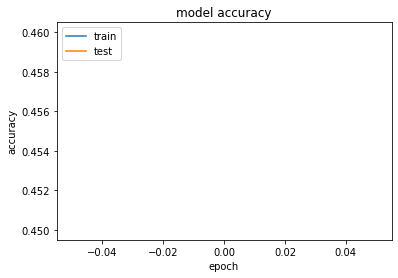

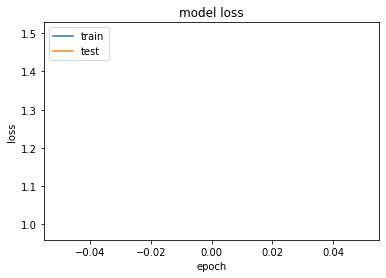

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline

# list all data in history
print(history_vgg16.history.keys())
# summarize history for accuracy
plt.plot(history_vgg16.history['accuracy'])
plt.plot(history_vgg16.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_vgg16.history['loss'])
plt.plot(history_vgg16.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

****Accuracy & Loss Graphs for Model VGG19**

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

****Accuracy & Loss Graphs for Model ResNet**

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

****Accuracy & Loss Graphs for Model Inception V3**

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

****Accuracy & Loss Graphs for Model MobileNet**

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()